import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the dataset

In [4]:
df = pd.read_csv('tedx_dataset.csv')
print(df.head())

                                idx       main_speaker  \
0  8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1  b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2  4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3  59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4  d227f2faf6ec185e54436d86463f499b      Daniel Finkel   

                                               title  \
0                    The intangible effects of walls   
1  It's OK to feel overwhelmed. Here's what to do...   
2                                  "Accept Who I Am"   
3               What it's really like to have autism   
4              Can you solve the sea monster riddle?   

                                             details           posted  \
0  More barriers exist now than at the end of Wor...  Posted Apr 2020   
1  If you're feeling anxious or fearful during th...  Posted Apr 2020   
2  Firing off her formidable beatboxing skills, m...  Posted Apr 2020   
3  "Autism is not a di

Data Preprocessing

In [5]:
df.shape
df.isnull().sum()

idx                0
main_speaker       1
title              0
details            0
posted             0
url                0
num_views       4258
dtype: int64

In [6]:
splitted = df['posted'].str.split(' ', expand=True)

Creating columns for month and year of the talk

In [7]:
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]

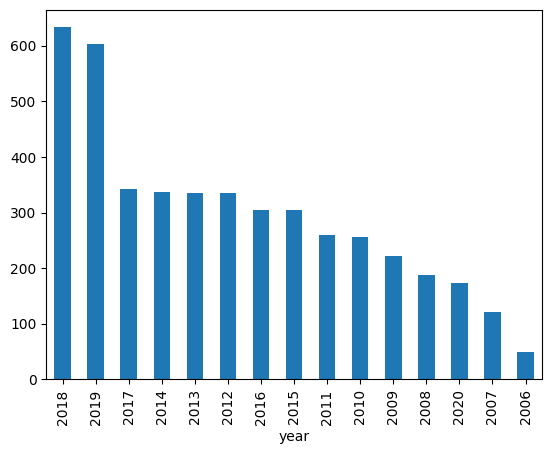

In [8]:
df['year'].value_counts().plot.bar()
plt.show()

Combining the title and the details of the talk.

In [9]:
df['details'] = df['title'] + ' ' + df['details']

Removing the unnecessary information

In [10]:
df = df[['main_speaker', 'details']]
df.dropna(inplace = True)
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...


Making a copy of this data for future use.

In [11]:
data = df.copy()

Removing punctuation and stopwords

In [12]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  imp_words = []
  # Storing the important words
  for word in str(text).split():
    word = word.lower()
    if word not in stop_words:
      imp_words.append(word)
  output = " ".join(imp_words)
  return output

Applying the function to the details column

In [13]:
df['details'] = df['details'].apply(lambda text: remove_stopwords(text))
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed. here's next feeling anxio...
2,Butterscotch,"""accept am"" firing formidable beatboxing skill..."
3,Ethan Lisi,"really like autism ""autism disease; another wa..."
4,Daniel Finkel,"solve sea monster riddle? according legend, ev..."


Removing punctuations

In [14]:
punctuations_list = string.punctuation

Function to remove punctuations from the text

In [15]:
def cleaning_punctuations(text):
	signal = str.maketrans('', '', punctuations_list)
	return text.translate(signal)

Applying the function to the details column

In [16]:
df['details'] = df['details'].apply(lambda x: cleaning_punctuations(x))
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed heres next feeling anxious...
2,Butterscotch,accept am firing formidable beatboxing skills ...
3,Ethan Lisi,really like autism autism disease another way ...
4,Daniel Finkel,solve sea monster riddle according legend ever...


Creating a word cloud to visualize the most common words in the details column

In [17]:
details_corpus = " ".join(df['details'])

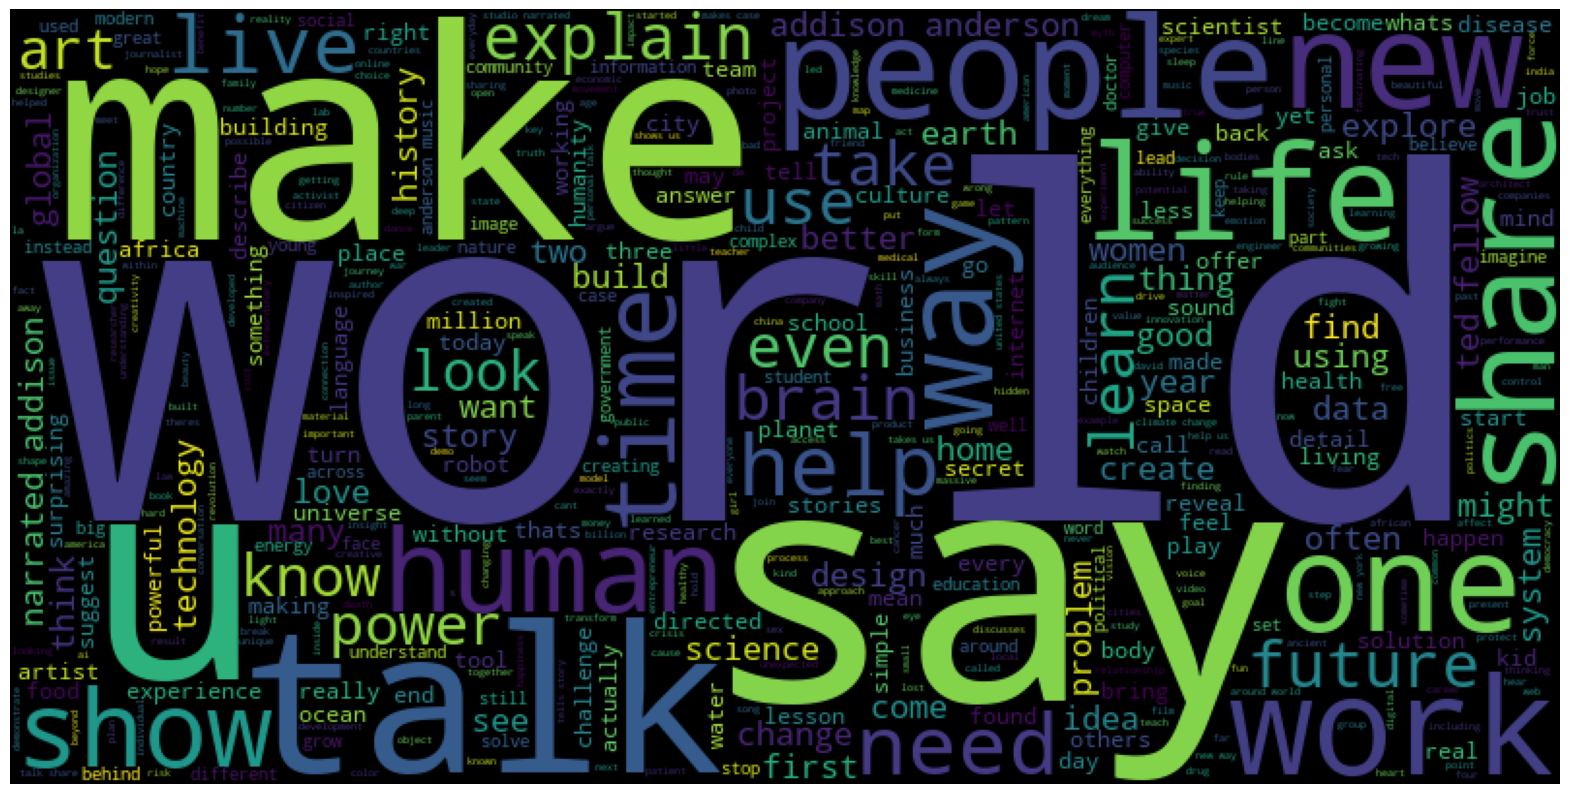

In [18]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000,
			width=800,
			height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

Creating a TF-IDF Vectorizer

In [19]:
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['details'])

TfidfVectorizer()

Function to get similarities for a given talk content

In [20]:
def get_similarities(talk_content, data=df):
	# Getting vector for the input talk_content.
	talk_array1 = vectorizer.transform(talk_content).toarray()
	# We will store similarity for each row of the dataset.
	sim = []
	pea = []
	for idx, row in data.iterrows():
		details = row['details']
		# Getting vector for current talk.
		talk_array2 = vectorizer.transform(
			data[data['details'] == details]['details']).toarray()
		# Calculating cosine similarities
		cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]
		# Calculating pearson correlation
		pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]
		sim.append(cos_sim)
		pea.append(pea_sim)
	return sim, pea

Function to get the top similar/recommended talks

In [21]:
def recommend_talks(talk_content, data=data):
	data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)
	data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
					False, False], inplace=True)
	print(data[['main_speaker', 'details']].head())

Example usage

In [22]:
talk_content = ['Time Management and working\
hard to become successful in life']

In [23]:
recommend_talks(talk_content)

                  main_speaker  \
1758           Laura Vanderkam   
2173             Philip Krinks   
66                   Fang Ruan   
1658  Chimamanda Ngozi Adichie   
3190            Nirmalya Kumar   

                                                details  
1758  How to gain control of your free time There ar...  
2173  Finding your personal mission in life Philip K...  
66    Management lessons from Chinese business and p...  
1658  We should all be feminists We teach girls that...  
3190  India's invisible innovation Can India become ...  
